# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



***

***

Очень офигенный ресурс по торчу на 27 часов!!! https://www.youtube.com/watch?v=Z_ikDlimN6A

***
***

In [1]:
import pickle
import numpy as np
import pandas as pd
import torch
import torchvision.transforms as tfs
import torch.nn as nn
import torchvision

from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights
from tqdm import tqdm, tqdm_notebook
from torchvision import transforms
from PIL import Image
from pathlib import Path
from torchvision.datasets import ImageFolder
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [2]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample)

In [3]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):

        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = Image.fromarray(x)

        if self.mode == 'train':
            augmentation = transforms.Compose([
                transforms.RandomResizedCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            x = augmentation(x)

        else:
            transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

            x = transform(x)

        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [4]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [5]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [6]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

In [7]:
#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('./train/')
TEST_DIR = Path('./testset')


#передадим в переменные непосредственнно тренировочные и тестовые файлы
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

train_val_labels = [path.parent.name for path in train_val_files]

train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [8]:
train_dataset = SimpsonsDataset(train_files, mode='train')
val_dataset = SimpsonsDataset(val_files, mode='val')
test_dataset = SimpsonsDataset(test_files, mode='test')

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

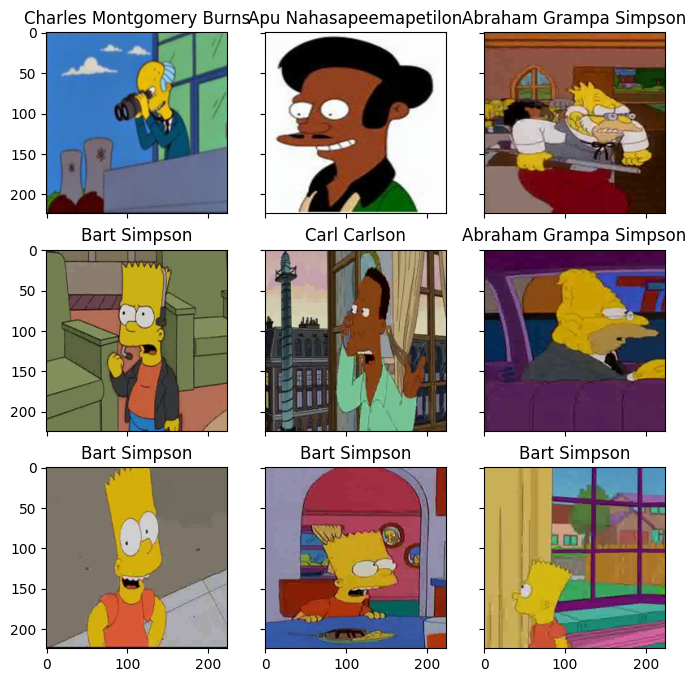

In [10]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [11]:
# Очень простая сеть
class SimpleCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Linear(96 * 5 * 5, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

А вот далее будем улучшать нейронки. Добавим несколько convolutional слоев, и по умолчанию применяем ReLU для активации.


In [12]:
# not so simple CNN
class CNN(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(in_features=2400, out_features=4800),
            nn.ReLU()
        )

        self.fc2 = nn.Sequential(
            nn.Linear(in_features=4800, out_features=4800),
            nn.ReLU(),
        )

        self.fc3 = nn.Sequential(
            nn.Linear(in_features=4800, out_features=42)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

Мы всегда* обучаем по эпохам. Давайте определим их: реализуем обучение (forward, backprop) и будем отдавать лосс и accuracy на каждой эпохе

In [13]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):

    model.train(True)

    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    scheduler.step()
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

И не забываем про валидационный датасет!

In [14]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

Обернем эпохи функцией трейн; будем также информировать юзера прогресс обучения. Прогресс-бар можно было бы улучшить, прикрутить tqdm, но это дело второстепенное.

In [15]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=1e-3)
        criterion = nn.CrossEntropyLoss()
        scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=5, gamma=0.1)

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt, scheduler)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [16]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

На собственном опыте могу сказать, что вычислять на CPU - больно. Поэтому сменим среду выполнения колаба на GPU (это вообще лучше бы сделать заранее) и переведем торч в режим CUDA torchvision augment.

In [18]:
gpu = torch.cuda.is_available()

if gpu:
    print('CUDA  is available')
    DEVICE = torch.device('cuda')
else:
    print('Not Available CUDA')
    DEVICE = torch.device('cpu')

CUDA  is available


Оборачиваем и отправляем все в GPU

In [19]:
classes = len(np.unique(train_dataset.labels))

cnn = CNN(classes).to(DEVICE)

In [20]:
weights = ResNet50_Weights.DEFAULT
resnet = resnet50(weights=weights)

# Set requires_grad = False for all parameters
for param in resnet.parameters():
    param.requires_grad = False

# Re-enable requires_grad for the last 3 layers
layers = list(resnet.children())
for layer in layers[-3:]:
    for param in layer.parameters():
        param.requires_grad = True


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 69.0MB/s]


Закомментировать

In [21]:
for name, param in resnet.named_parameters():
    print(f"{name}: {param.requires_grad}")

conv1.weight: False
bn1.weight: False
bn1.bias: False
layer1.0.conv1.weight: False
layer1.0.bn1.weight: False
layer1.0.bn1.bias: False
layer1.0.conv2.weight: False
layer1.0.bn2.weight: False
layer1.0.bn2.bias: False
layer1.0.conv3.weight: False
layer1.0.bn3.weight: False
layer1.0.bn3.bias: False
layer1.0.downsample.0.weight: False
layer1.0.downsample.1.weight: False
layer1.0.downsample.1.bias: False
layer1.1.conv1.weight: False
layer1.1.bn1.weight: False
layer1.1.bn1.bias: False
layer1.1.conv2.weight: False
layer1.1.bn2.weight: False
layer1.1.bn2.bias: False
layer1.1.conv3.weight: False
layer1.1.bn3.weight: False
layer1.1.bn3.bias: False
layer1.2.conv1.weight: False
layer1.2.bn1.weight: False
layer1.2.bn1.bias: False
layer1.2.conv2.weight: False
layer1.2.bn2.weight: False
layer1.2.bn2.bias: False
layer1.2.conv3.weight: False
layer1.2.bn3.weight: False
layer1.2.bn3.bias: False
layer2.0.conv1.weight: False
layer2.0.bn1.weight: False
layer2.0.bn1.bias: False
layer2.0.conv2.weight: False
l

In [22]:
in_features = 2048
out_features = 42
resnet.fc = nn.Linear(in_features, out_features)
resnet = resnet.to(DEVICE)

**Долгожданное обучение!**
После обучения модели, мы бережно закинем историю в .csv

In [23]:
history = train(train_dataset, val_dataset, model=resnet, epochs=10, batch_size=64)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 1.0660280910287894


epoch:  10%|█         | 1/10 [03:38<32:48, 218.73s/it]


Epoch 001 train_loss: 1.0660     val_loss 0.4723 train_acc 0.7310 val_acc 0.8752
loss 0.5410302533652496


epoch:  20%|██        | 2/10 [07:13<28:51, 216.39s/it]


Epoch 002 train_loss: 0.5410     val_loss 0.3035 train_acc 0.8547 val_acc 0.9272
loss 0.4524903891268669


epoch:  30%|███       | 3/10 [10:46<25:04, 214.87s/it]


Epoch 003 train_loss: 0.4525     val_loss 0.2982 train_acc 0.8801 val_acc 0.9238
loss 0.3901236518506556


epoch:  40%|████      | 4/10 [14:21<21:29, 214.93s/it]


Epoch 004 train_loss: 0.3901     val_loss 0.2815 train_acc 0.8964 val_acc 0.9297
loss 0.36584012545144545


epoch:  50%|█████     | 5/10 [17:57<17:56, 215.23s/it]


Epoch 005 train_loss: 0.3658     val_loss 0.2468 train_acc 0.9008 val_acc 0.9385
loss 0.3022251552787964


epoch:  60%|██████    | 6/10 [21:32<14:20, 215.09s/it]


Epoch 006 train_loss: 0.3022     val_loss 0.1784 train_acc 0.9183 val_acc 0.9545
loss 0.2724740109942401


epoch:  70%|███████   | 7/10 [25:07<10:45, 215.10s/it]


Epoch 007 train_loss: 0.2725     val_loss 0.1633 train_acc 0.9281 val_acc 0.9587
loss 0.26928136521417995


epoch:  80%|████████  | 8/10 [28:41<07:09, 214.79s/it]


Epoch 008 train_loss: 0.2693     val_loss 0.1576 train_acc 0.9276 val_acc 0.9595
loss 0.24450881110117598


epoch:  90%|█████████ | 9/10 [32:15<03:34, 214.47s/it]


Epoch 009 train_loss: 0.2445     val_loss 0.1588 train_acc 0.9321 val_acc 0.9610
loss 0.24862351425096968


epoch: 100%|██████████| 10/10 [35:50<00:00, 215.03s/it]


Epoch 010 train_loss: 0.2486     val_loss 0.1613 train_acc 0.9315 val_acc 0.9606


**Playground нашей машины принятия решений**

In [24]:
loss, acc, val_loss, val_acc = zip(*history)

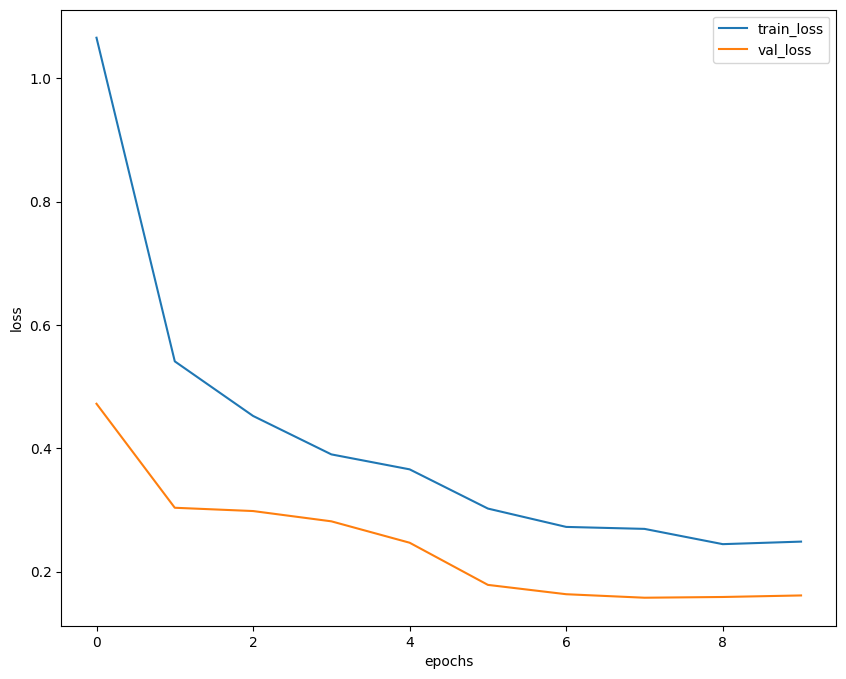

In [25]:
plt.figure(figsize=(10, 8))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Предсказание, для одной картинки:

In [32]:
def predict_one_sample(model, inputs, device=DEVICE):
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [33]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(resnet, ex_img.unsqueeze(0))

idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(resnet, imgs)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [34]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1 score:", f1)

F1 score: 1.0


Рандомно сгенерим несколько фоток, чтобы сравнить наши предсказания с органической системой компьютерного зрения!

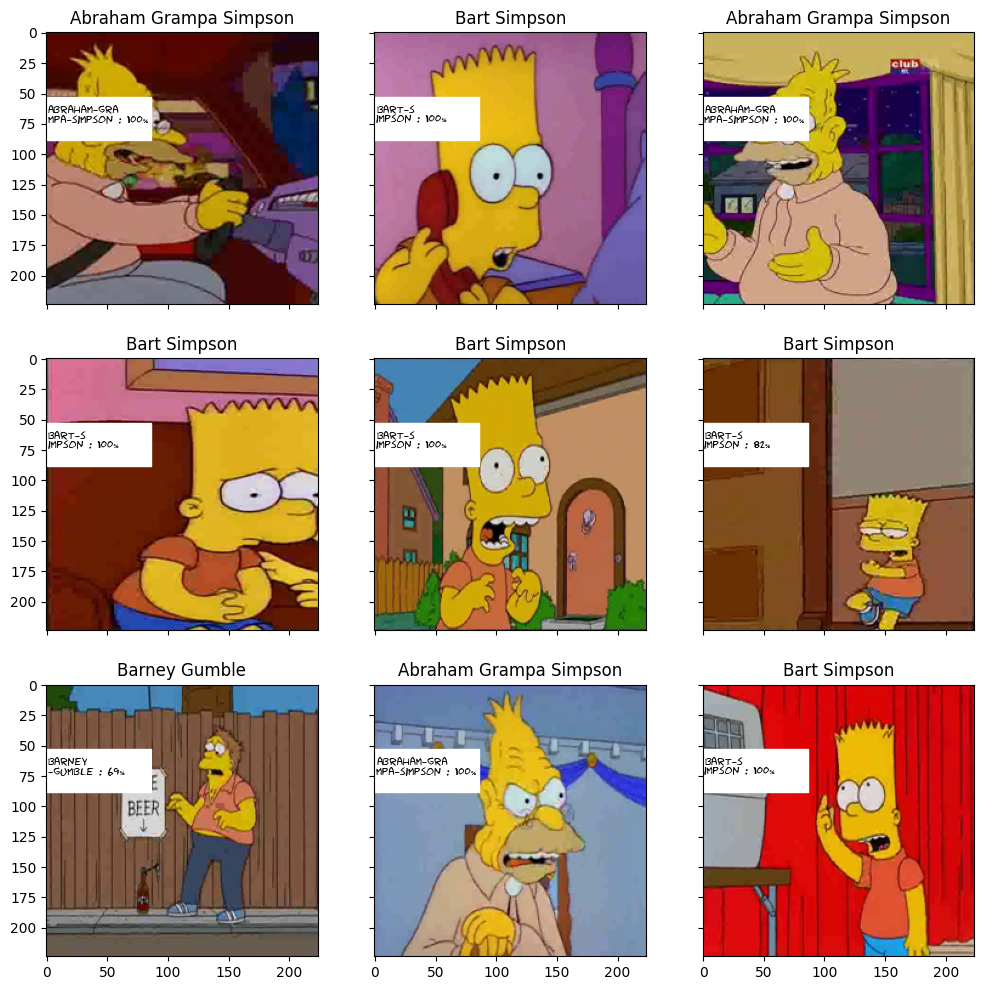

In [35]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(resnet, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Завершение работы и отправка результатов на кагл

In [30]:
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(resnet, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [31]:
pd.DataFrame(
    {'Id': test_filenames, 'Expected': preds}
            ).to_csv('preds.csv', index=False)